## Neural Networks
使用torch.nn包来构建神经网络。

上一讲已经讲过了autograd，nn包依赖autograd包来定义模型并求导。 一个nn.Module包含各个层和一个forward(input)方法，该方法返回output。
例如：
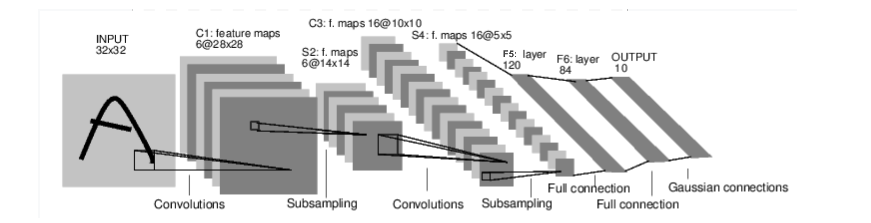
它是一个简单的前馈神经网络，它接受一个输入，然后一层接着一层地传递，最后输出计算的结果。

神经网络的典型训练过程如下：

1. 定义包含一些可学习的参数(或者叫权重)神经网络模型；
2. 在数据集上迭代；
3. 通过神经网络处理输入；
4. 计算损失(输出结果和正确值的差值大小)；
5. 将梯度反向传播回网络的参数；
6. 更新网络的参数，主要使用如下简单的更新原则：  weight = weight - learning_rate * gradient

## 定义网络
开始定义一个网络：



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [3]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


在模型中必须要定义 forward 函数，backward 函数（用来计算梯度）会被autograd自动创建。 可以在 forward 函数中使用任何针对 Tensor 的操作。

net.parameters()返回可被学习的参数（权重）列表和值

In [4]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


测试随机输入32×32。 注：这个网络（LeNet）期望的输入大小是32×32，如果使用MNIST数据集来训练这个网络，请把图片大小重新调整到32×32。

In [5]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.1229, -0.0932, -0.0988,  0.0107,  0.0085, -0.0355,  0.1844, -0.1223,
         -0.0518, -0.0177]], grad_fn=<AddmmBackward>)


将所有参数的梯度缓存清零，然后进行随机梯度的的反向传播：

In [6]:
net.zero_grad()
out.backward(torch.randn(1, 10))

## Note
``torch.nn`` 只支持小批量输入。整个 ``torch.nn`` 包都只支持小批量样本，而不支持单个样本。 例如，``nn.Conv2d`` 接受一个4维的张量， ``每一维分别是sSamples * nChannels * Height * Width（样本数*通道数*高*宽）``。 如果你有单个样本，只需使用 ``input.unsqueeze(0)`` 来添加其它的维数




在继续之前，我们回顾一下到目前为止用到的类。

回顾:

- torch.Tensor：一个用过自动调用 backward()实现支持自动梯度计算的 多维数组 ， 并且保存关于这个向量的梯度 w.r.t.
- nn.Module：神经网络模块。封装参数、移动到GPU上运行、导出、加载等。
- nn.Parameter：一种变量，当把它赋值给一个Module时，被 自动 地注册为一个参数。
- autograd.Function：实现一个自动求导操作的前向和反向定义，每个变量操作至少创建一个函数节点，每一个Tensor的操作都回创建一个接到创建Tensor和 编码其历史 的函数的Function节点。
重点如下：

- 定义一个网络
- 处理输入，调用backword
还剩：

- 计算损失
- 更新网络权重

## 损失函数
一个损失函数接受一对 (output, target) 作为输入，计算一个值来估计网络的输出和目标值相差多少。

**output为网络的输出，target为实际值**

nn包中有很多不同的损失函数。 nn.MSELoss是一个比较简单的损失函数，它计算输出和目标间的均方误差， 例如：






In [10]:
output = net(input)
target = torch.randn(10)  # 随机值作为样例
target = target.view(1, -1)  # 使target和output的shape相同
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.1314, grad_fn=<MseLossBackward>)


In [11]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

## 反向传播
调用loss.backward()获得反向传播的误差。

但是在调用前需要清除已存在的梯度，否则梯度将被累加到已存在的梯度。

现在，我们将调用loss.backward()，并查看conv1层的偏差（bias）项在反向传播前后的梯度。

In [12]:
net.zero_grad()     # 清除梯度

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0082,  0.0124, -0.0109,  0.0123,  0.0061, -0.0015])


## 更新权重
在实践中最简单的权重更新规则是随机梯度下降（SGD）：

 ``weight = weight - learning_rate * gradient``

我们可以使用简单的Python代码实现这个规则：
```
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
```
但是当使用神经网络是想要使用各种不同的更新规则时，比如SGD、Nesterov-SGD、Adam、RMSPROP等，PyTorch中构建了一个包torch.optim实现了所有的这些规则。 使用它们非常简单：

In [13]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

.. 注意::

  观察如何使用``optimizer.zero_grad()``手动将梯度缓冲区设置为零。
  这是因为梯度是按Backprop部分中的说明累积的。